In [3]:
import warnings
warnings.filterwarnings("ignore") # warnings 무시

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

data 읽어오기

In [4]:
data_dir = '/kaggle/input/aiffel-data-exp2' # 케글에서 data 이용하기에 해당 라인으로 사용 하였습니다.
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [5]:
train.head() # 잘 읽어왔는지 어떤 컬럼들이 존재하는지 확인

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int) # date 형식을 int형로 변환

In [7]:
y = train['price'] # 가격을 예측하기에 y값으로 사용
del train['price'] # y값으로 사용하기에 컬럼 삭제
del train['id'] # id 컬럼은 가격예측에 필요없기에 삭제
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test Data도 전처리를 진행합니다.

In [8]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


y가 잘 분포하는지 확인 해보겠습니다.

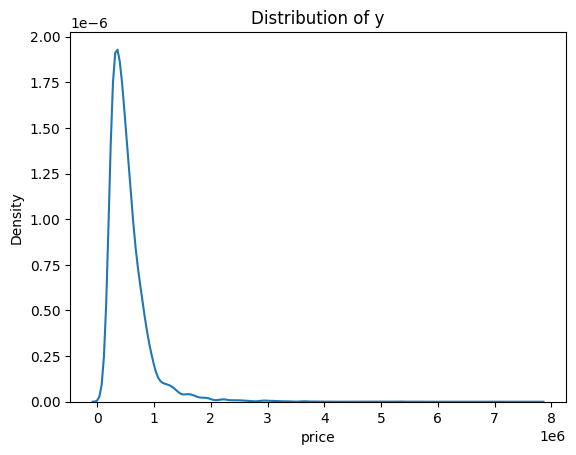

In [9]:
sns.kdeplot(y) #가격 그래프 표
# 그래프 제목 설정
plt.title("Distribution of y")
# 그래프 출력
plt.show()

그래프가 한쪽으로 치우쳐져 있어서 로그 변환을 적용할 것입니다.

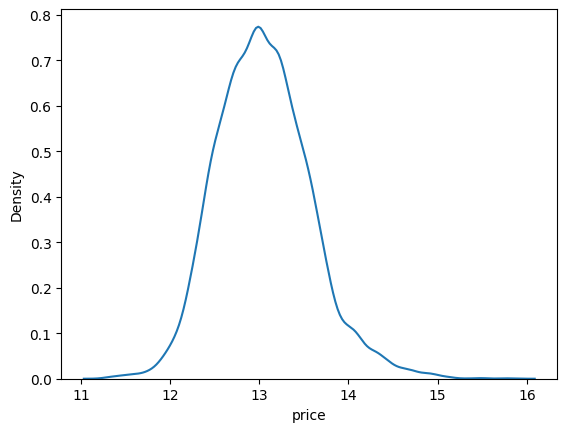

In [10]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

정규분포형식으로 바뀌었습니다.
아래는 모델을 정의 할 것입니다.

In [11]:
model = LGBMRegressor(learning_rate=0.1,  # 학습률
                      max_depth=20,         # 트리의 최대 깊이
                      num_leaves=18,       # 트리의 리프 개수
                      feature_fraction=0.8, # feature 샘플링 비율
                      bagging_fraction=0.8, # 데이터 샘플링 비율
                      n_estimators=2000,   # 트리의 개수
                      random_state=42)  # 재현성을 위한 랜덤 시드 값

각 파라미터들의 설명을 주석으로 하였고, 해당 파라미터들을 변경하며 시도하였습니다.

In [12]:
model.fit(train, y) # 학습
prediction_train = model.predict(train)
rmse = np.sqrt(mean_squared_error(y, prediction_train))
print(rmse)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
0.06271399121529961


데이터 전처리 과정에서 y값(score)를 log변환하여 학습하였기에,

추론 후 결과를 확인 할때에 지수함수를 적용합니다.

In [13]:
prediction = model.predict(test) # 추론
prediction = np.expm1(prediction)

이제 kaggle에 score를 확인하기 위해  csv를 만들어야 합니다.

sample_submission.csv에 test 결과를 합치는 작업입니다.

In [14]:
submission_path = os.path.join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [15]:
submission['price'] = prediction # kaggle에 올릴 데이터에 price 추가
submission.head()

,id,price
0,15035,5.010636e+05
1,15036,4.897063e+05
2,15037,1.217912e+06
3,15038,2.887095e+05
4,15039,3.183772e+05


In [16]:
#첫번째 인자는 저장할 폴더, 2번째 인자는 모델명, 3번째 인자는 RMSE 값
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('/kaggle/working/', 'lgbm', str(rmse))
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/kaggle/working//submission_lgbm_RMSLE_0.06271399121529961.csv


약 60번의 하이퍼 파라미터 변경 시도 끝에 private score가 109666.00936 public score가 106814.93484 점으로 평가기준에 통과 하였습니다.


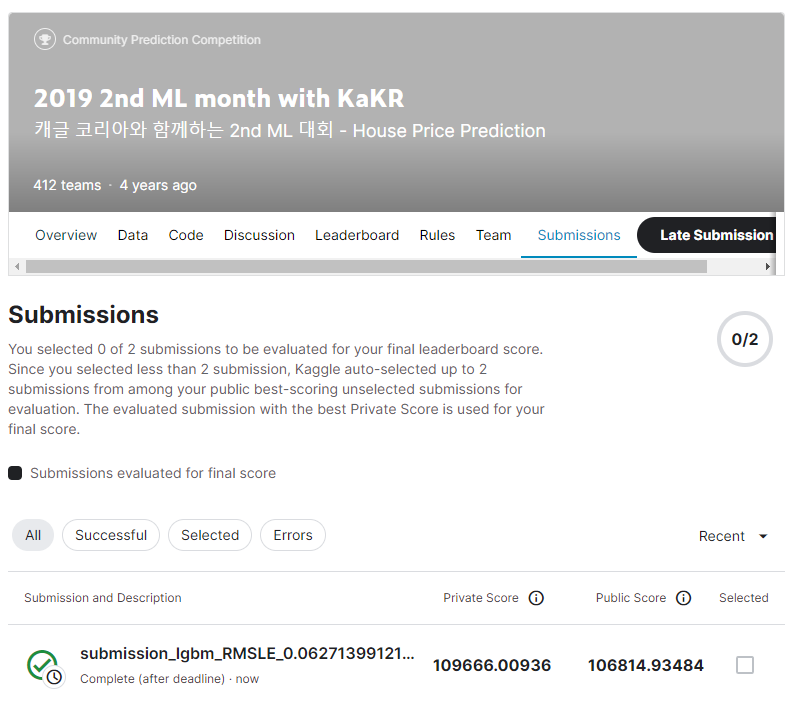